In [4]:
import matplotlib as mpl

current_font_size = mpl.rcParams['font.size']
# mpl.rcParams['font.size'] = current_font_size * 1.5
mpl.rcParams['font.family'] = 'Noto Sans CJK JP'

In [1]:
def create_paired_pplt_widths(L, Lambda0, chirp_factor=0.0):
    widths = []
    z_current = 0.0
    pair_index = 0  # ペアのインデックス
    while z_current < L:
        # ペアごとにチャープを計算
        current_lambda = Lambda0 / (1 + chirp_factor * pair_index)
        half_period = current_lambda / 2.0
        # 次のペア全体がLを超えないか確認
        if z_current + current_lambda <= L:
            # 1ペア（2つのドメイン）を追加
            widths.append(half_period)
            widths.append(half_period)
            z_current += current_lambda
            # 次のペアへ
            pair_index += 1
        else:
            # Lを超える場合はループを終了
            break
    return widths


def create_pplt_widths(L, Lambda0, chirp_factor=0.0):
    widths = []
    z_current = 0.0
    while z_current < L:
        # 現在位置での周期長を計算（チャープ関数）
        # chirp_factor = 0 の場合は均一な構造になる
        current_lambda = Lambda0 / (1 + chirp_factor * z_current)
        half_period = current_lambda / 2.0
        # 正領域の幅を追加
        widths.append(half_period)
        # 負領域の幅を追加（デバイスの境界を考慮）
        if z_current + current_lambda < L:
            widths.append(half_period)
        # 次の周期へ
        z_current += current_lambda
    return widths

In [2]:
from syuron import shg

T = 70
L = 2000
A0 = 1.0
B0 = 0.0
kappa_magnitude = 1.31e-05
grating_period = 7.2
widths = create_pplt_widths(L, grating_period, 0.0001)


device = shg.PPMgOSLT(widths, kappa_magnitude)
# device.show_structure()

Calculating SHG Efficiency: 100%|██████████| 1000/1000 [00:19<00:00, 51.54it/s]
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25563 (\N{CJK UNIFIED IDEOGRAPH-63DB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21177 (\N{CJK UNIFIED IDEOGRAPH-52B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/workspaces/mictlan/.venv/lib/python


最大効率: 7.054767801734671e-06
最大効率に対応する波長: 0.979108108108108 µm


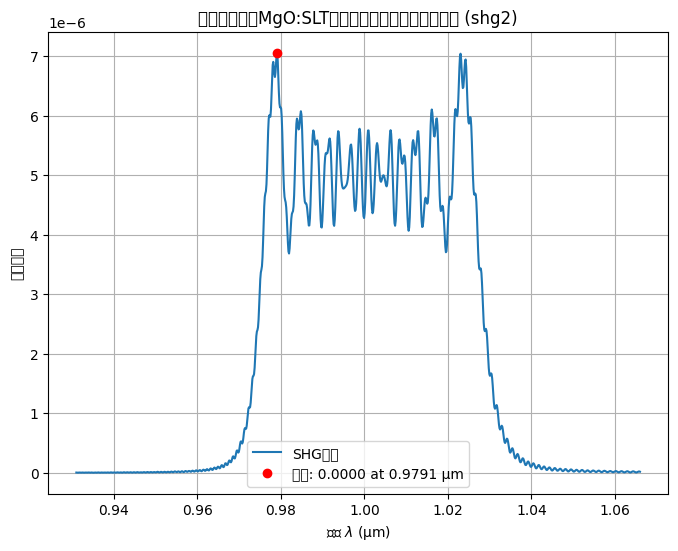

In [3]:
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

wavelength = 1.031
lambda_min = wavelength - 0.1
lambda_max = wavelength + 0.035
lambda_values = np.linspace(lambda_min, lambda_max, 1000)


def solve_eff(lam):
    eff_solver = shg.EulerNCMESolver(device, lam, T)
    return eff_solver.solve(A0, B0)


with ProcessPoolExecutor() as executor:
    efficiencies = list(tqdm(
        executor.map(solve_eff, lambda_values),
        total=len(lambda_values),
        desc="Calculating SHG Efficiency"
    ))
plt.figure(figsize=(8, 6))
plt.plot(lambda_values, efficiencies, label="SHG効率")
plt.xlabel(r"波長 $\lambda$ (µm)")
plt.ylabel("変換効率")
plt.title("チャープしたMgO:SLTの変換効率のスペクトル分布 (shg2)")
plt.grid(True)
max_efficiency = max(efficiencies)
max_index = efficiencies.index(max_efficiency)
max_lambda = lambda_values[max_index]
print(f"\n最大効率: {max_efficiency}")
print(f"最大効率に対応する波長: {max_lambda} µm")
plt.plot(max_lambda, max_efficiency, 'ro',
         label=f"最大: {max_efficiency:.4f} at {max_lambda:.4f} µm")
plt.legend()
plt.show()